# Scenarios Score Analysis

In [78]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
import matplotlib.pyplot as plt
import pandas as pd

### Authorization

Generate a key in the Firebase Console!

In [ ]:
cred = credentials.Certificate("/Users/lauracorssac/idp-lets-go-e92b8-firebase-adminsdk-fbsvc-42ad0e1400.json")
firebase_admin.initialize_app(cred)

### Users Fetch

Warning: Don't do it often! This counts as one read per user, so it might get expensive!

In [80]:
db = firestore.client()

users_ref = db.collection("users")
docs = users_ref.stream()

user_data = []
for doc in docs:
    user_data.append(doc.to_dict())

print(user_data)

[{'birthYear': '1998', 'trials': [{'responseTime': 1622, 'step': 2}, {'responseTime': 2208, 'step': 1}, {'responseTime': 1992, 'step': 7}, {'responseTime': 3011, 'step': 3}, {'responseTime': 2644, 'step': 3}, {'responseTime': 1890, 'step': 2}, {'responseTime': 1805, 'step': 5}, {'responseTime': 1673, 'step': 5}, {'responseTime': 4064, 'step': 3}, {'responseTime': 2342, 'step': 1}, {'responseTime': 8363, 'step': 1}, {'responseTime': 1522, 'step': 1}, {'responseTime': 3747, 'step': 2}, {'responseTime': 2923, 'step': 4}, {'responseTime': 1973, 'step': 6}, {'responseTime': 1973, 'step': 4}, {'responseTime': 2142, 'step': 1}, {'responseTime': 2862, 'step': 6}, {'responseTime': 1972, 'step': 3}, {'responseTime': 4565, 'step': 6}, {'responseTime': 1891, 'step': 4}, {'responseTime': 2259, 'step': 2}, {'responseTime': 1870, 'step': 6}, {'responseTime': 5773, 'step': 7}, {'responseTime': 2727, 'step': 6}, {'responseTime': 3695, 'step': 7}, {'responseTime': 2007, 'step': 5}, {'responseTime': 1488

### Score Computation

In [81]:
from pydantic import BaseModel


class Question(BaseModel):
    bias_interrupting: int
    bias_reinforcing: int

questions = [
    
    # 1
    Question(bias_interrupting=1, bias_reinforcing=2),
    
    # 2
    Question(bias_interrupting=2, bias_reinforcing=1),

    # 3
    Question(bias_interrupting=3, bias_reinforcing=0),

    # 4
    Question(bias_interrupting=0, bias_reinforcing=3),

    # 5
    Question(bias_interrupting=2, bias_reinforcing=1),

    # 6
    Question(bias_interrupting=3, bias_reinforcing=2),

    # 7
    Question(bias_interrupting=0, bias_reinforcing=2),

    # 8
    Question(bias_interrupting=3, bias_reinforcing=1),

    # 9
    Question(bias_interrupting=1, bias_reinforcing=3),

    # 10
    Question(bias_interrupting=3, bias_reinforcing=0),

]

In [ ]:
for user in user_data:
    answers = user.get("answers")
    user_score = 0
    for answer, question in zip(answers, questions):
        least_index = answer.get("leastIndex")
        most_index = answer.get("mostIndex")
        if most_index == question.bias_interrupting or least_index == question.bias_reinforcing:
            user_score += 1
        if most_index == question.bias_reinforcing or least_index == question.bias_interrupting:
            user_score -= 1

    user["questions_score"] = user_score

questions_scores = [user.get("questions_score") for user in user_data]

questions_scores

[4, 8, 3, 10, 8, 10, -3, 3, -2, 2, 6, 6, 3, 4, 2, 4, 5, 6, 1, -4, 8, -4, -1]

In [83]:
df = pd.DataFrame(user_data)

## Scenarios Score per Group

In [84]:
questions_scores_control = [user.get("questions_score") for user in user_data if user.get("group") == "control"]
questions_scores_target = [user.get("questions_score") for user in user_data if user.get("group") == "target"]

print(questions_scores_control)
print(questions_scores_target)

avg_control = sum(questions_scores_control) / len(questions_scores_control)
avg_target = sum(questions_scores_target) / len(questions_scores_target)

print(avg_control)
print(avg_target)

[10, 10, -3, -2, 6, 6, 3, 5, 6, -4, 8]
[4, 8, 3, 8, 3, 2, 4, 2, 4, 1, -4, -1]
4.090909090909091
2.8333333333333335


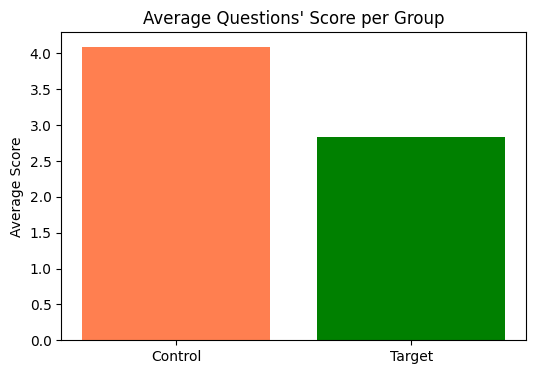

In [85]:
group_names = ['Control', 'Target']
group_averages = [avg_control, avg_target]

plt.figure(figsize=(6, 4))
plt.ylabel("Average Score")
plt.title("Average Questions' Score per Group")

bars = plt.bar(group_names, group_averages, color=['coral', 'green'])

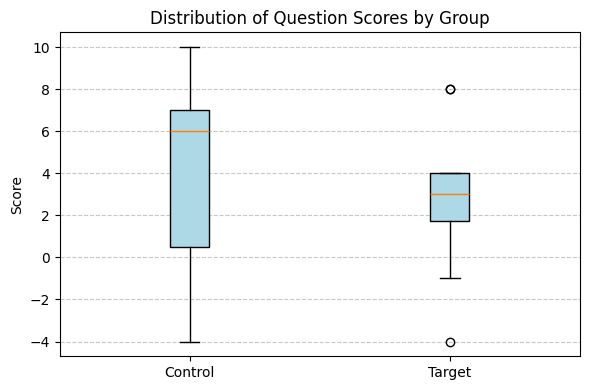

In [86]:
data = [questions_scores_control, questions_scores_target]
group_names = ['Control', 'Target']

plt.figure(figsize=(6, 4))
plt.boxplot(
    data, 
    tick_labels=group_names, 
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),
)

plt.title('Distribution of Question Scores by Group')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Scenario Score per Gender

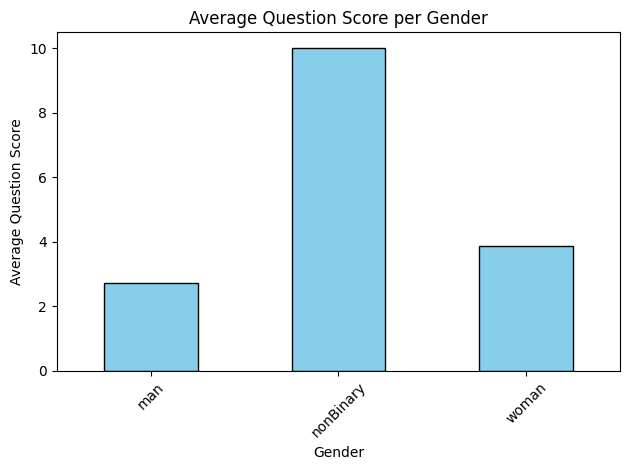

In [87]:
avg_scores = df.groupby('gender')['questions_score'].mean()

# Step 2: Plot as a histogram (bar plot for categorical data)
avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')

# Step 3: Add labels and title
plt.xlabel('Gender')
plt.ylabel('Average Question Score')
plt.title('Average Question Score per Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

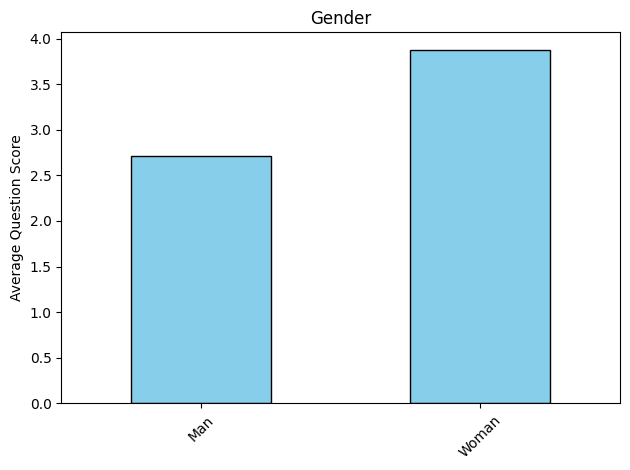

In [105]:
gender_counts = df['gender'].value_counts(normalize=True)

# Step 2: Keep only genders that make up at least 10% of the total
valid_genders = gender_counts[gender_counts >= 0.10].index

# Step 3: Filter the DataFrame
filtered_df = df[df['gender'].isin(valid_genders)]

# Step 4: Group and plot
avg_scores = filtered_df.groupby('gender')['questions_score'].mean()

label_map = {
    "man": "Man",
    "woman": "Woman",
}

ax = avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('')
plt.title('Gender')
plt.ylabel('Average Question Score')
ax.set_xticklabels([label_map.get(r, r) for r in avg_scores.index], rotation=45)
plt.tight_layout()
plt.show()

## Scenario Score per Ethinicity

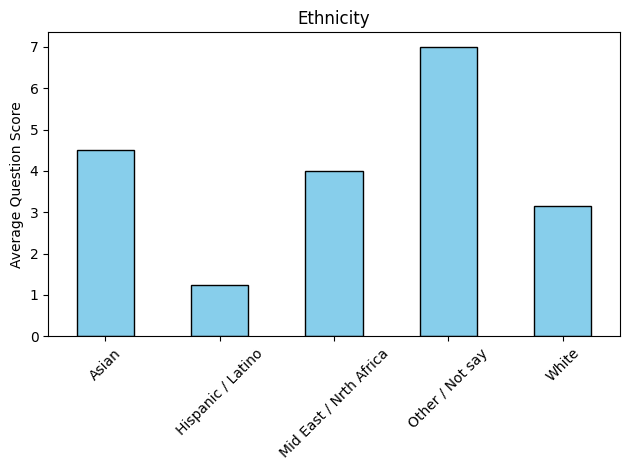

In [ ]:
# Expand the occupations list into multiple rows per user
df_exploded = df.explode('races')

# Group and compute average score per occupation
avg_scores = df_exploded.groupby('races')['questions_score'].mean()

ax = avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')

label_map = {
    "Asian": "Asian",
    "Hispanic / Latino": "Hispanic / Latino",
    "Middle Eastern / North African": "Mid East / Nrth Africa",
    "Other / Prefer not to say": "Other / Not say",
    "White": "White"
}

plt.ylabel('Average Question Score')
plt.xlabel('')
plt.title('Ethnicity')
ax.set_xticklabels([label_map.get(r, r) for r in avg_scores.index], rotation=45)

plt.tight_layout()
plt.show()

## Scenario Score per Occupation

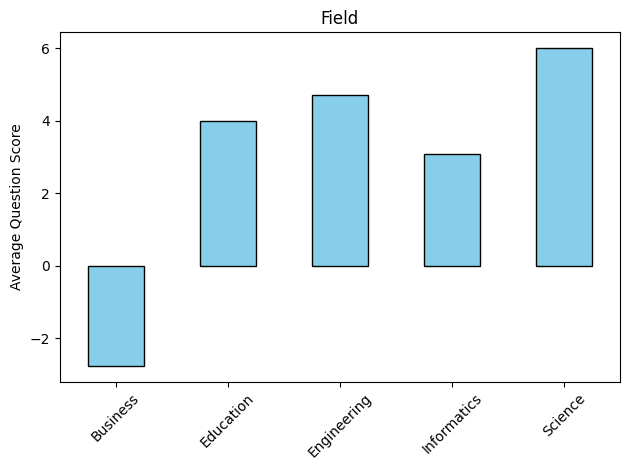

In [98]:
# Expand the occupations list into multiple rows per user
df_exploded = df.explode('professions')

# Group and compute average score per occupation
avg_scores = df_exploded.groupby('professions')['questions_score'].mean()

avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('')
plt.ylabel('Average Question Score')
plt.title('Field')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

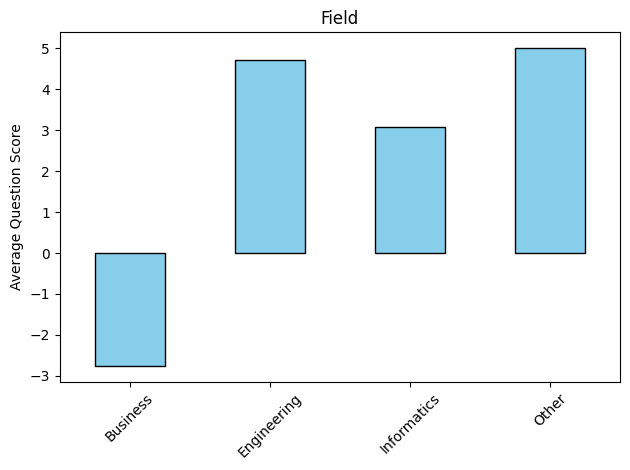

In [99]:
# Get normalized occupation counts
occupation_counts = df_exploded['professions'].value_counts(normalize=True)

# Define threshold and split valid vs other
valid_occupations = occupation_counts[occupation_counts >= 0.10].index
other_occupations = occupation_counts[occupation_counts < 0.10].index

# Filter dataframes
main_df = df_exploded[df_exploded['professions'].isin(valid_occupations)]
other_df = df_exploded[df_exploded['professions'].isin(other_occupations)]

# Compute averages
main_avg_scores = main_df.groupby('professions')['questions_score'].mean()
other_avg_score = other_df['questions_score'].mean()

# Add "Other" category
avg_scores_with_other = main_avg_scores.copy()
avg_scores_with_other['Other'] = other_avg_score

# Plot
avg_scores_with_other.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('')
plt.ylabel('Average Question Score')
plt.title('Field')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Scenario Score per Education

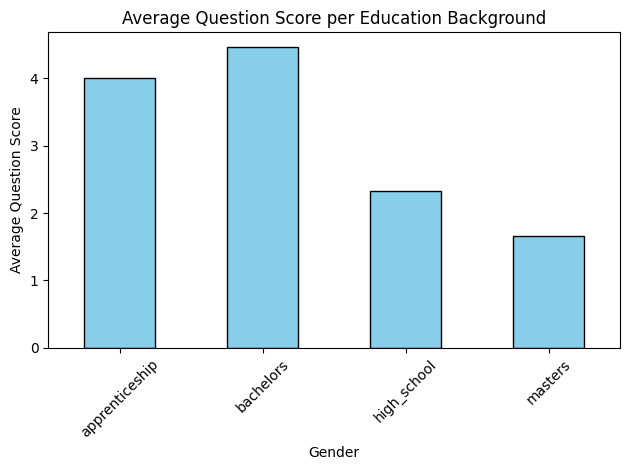

In [92]:
avg_scores = df.groupby('education')['questions_score'].mean()

# Step 2: Plot as a histogram (bar plot for categorical data)
avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')

# Step 3: Add labels and title
plt.xlabel('Gender')
plt.ylabel('Average Question Score')
plt.title('Average Question Score per Education Background')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

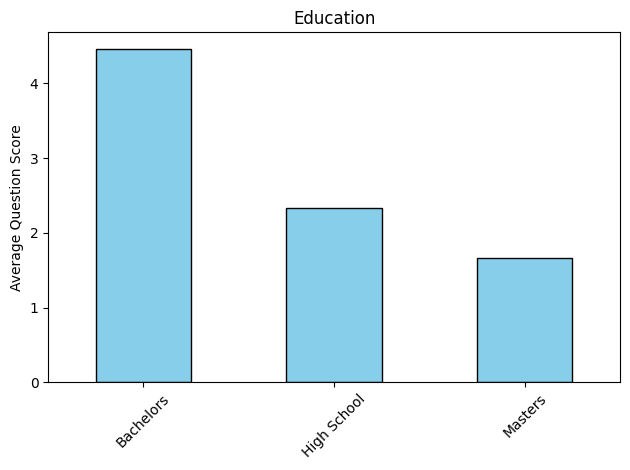

In [ ]:
edu_counts = df['education'].value_counts(normalize=True)

valid_edu = edu_counts[edu_counts >= 0.10].index


filtered_df = df[df['education'].isin(valid_edu)]

avg_scores = filtered_df.groupby('education')['questions_score'].mean()

avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')


plt.xlabel('')
plt.ylabel('Average Question Score')
plt.title('Education')
plt.xticks(rotation=45, ticks=range(3), labels=["Bachelors", "High School", "Masters"])
plt.tight_layout()
plt.show()

# Scenarios Score per Age

/var/folders/bc/gcpryyxs74146gl1yfg2msyw0000gn/T/ipykernel_23924/2841056154.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_scores = df.groupby('age_group')['questions_score'].mean()


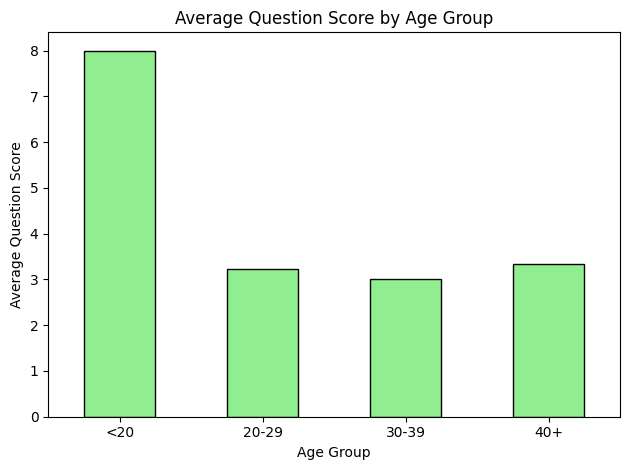

In [101]:
df['age'] = 2025 - df['birthYear'].astype(int)

bins = [0, 19, 29, 39, float('inf')]
labels = ['<20', '20-29', '30-39', '40+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

avg_scores = df.groupby('age_group')['questions_score'].mean()

avg_scores.plot(kind='bar', color='lightgreen', edgecolor='black')

plt.xlabel('Age Group')
plt.ylabel('Average Question Score')
plt.title('Average Question Score by Age Group')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

age_group
20-29    3.222222
40+      3.333333
Other    5.500000
Name: questions_score, dtype: float64


/var/folders/bc/gcpryyxs74146gl1yfg2msyw0000gn/T/ipykernel_23924/3299163788.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  main_avg_scores = main_df.groupby('age_group')['questions_score'].mean()


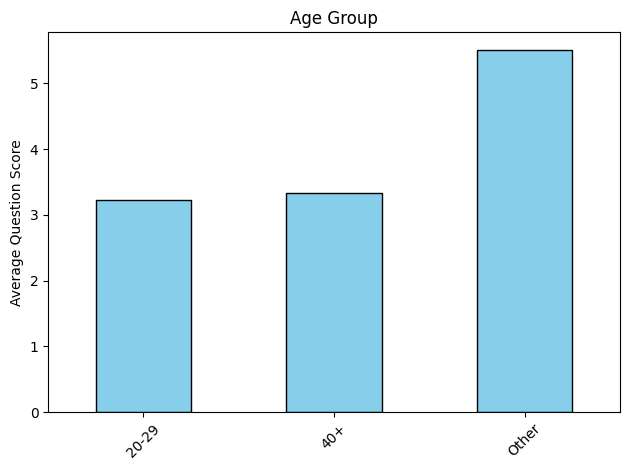

In [ ]:
age_group_counts = df['age_group'].value_counts(normalize=True)

main_age_groups = age_group_counts[age_group_counts >= 0.10].index
other_age_groups = age_group_counts[age_group_counts < 0.10].index


main_df = df[df['age_group'].isin(main_age_groups)]
other_df = df[df['age_group'].isin(other_age_groups)]

main_avg_scores = main_df.groupby('age_group')['questions_score'].mean()
other_avg_score = other_df['questions_score'].mean()

scores = main_avg_scores.copy()
scores['Other'] = other_avg_score

scores = scores.dropna()
print(scores)

scores.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('')
plt.ylabel('Average Question Score')
plt.title('Age Group')
plt.xticks(rotation=45, ticks=range(3))
plt.tight_layout()
plt.show()